Fitting 5 folds for each of 108 candidates, totalling 540 fits
🔹 Random Forest Accuracy: 0.8225

🔹 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      1607
           1       0.54      0.65      0.59       393

    accuracy                           0.82      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.84      0.82      0.83      2000



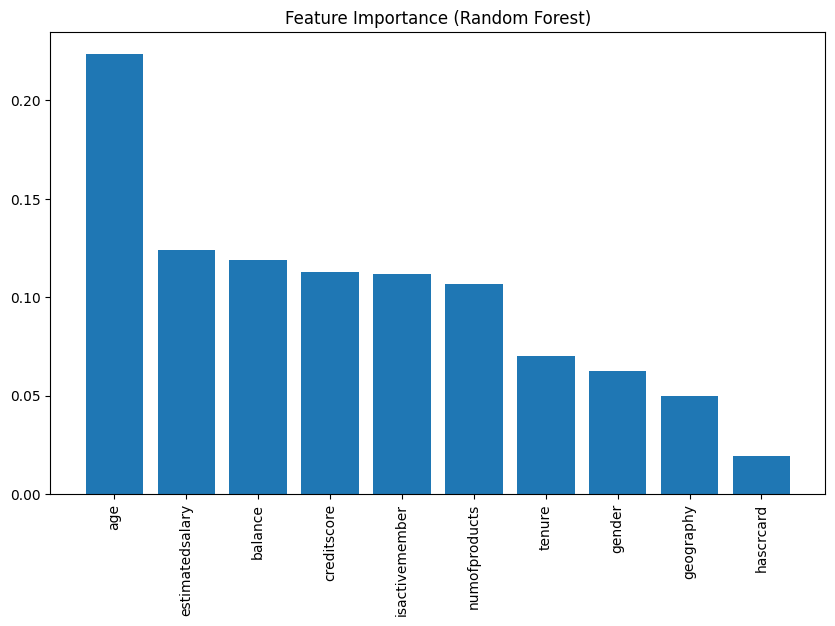

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:48:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 XGBoost Accuracy: 0.8175

🔹 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1607
           1       0.53      0.65      0.58       393

    accuracy                           0.82      2000
   macro avg       0.72      0.75      0.73      2000
weighted avg       0.83      0.82      0.82      2000



In [37]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load Dataset
df = pd.read_csv("processed_data.csv")  # Ensure the correct file path

# Drop Unnecessary Columns
df.drop(columns=["rownumber", "customerid", "surname"], inplace=True)

# Encode Categorical Features
label_encoder = LabelEncoder()
df["geography"] = label_encoder.fit_transform(df["geography"])
df["gender"] = label_encoder.fit_transform(df["gender"])

# Split Data
X = df.drop(columns=["exited"])
y = df["exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Best Random Forest Model
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluate Random Forest
print("🔹 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n🔹 Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Feature Importance Analysis
feature_importance = best_rf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot Feature Importance
plt.figure(figsize=(10,6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(feature_importance)), np.array(feature_names)[sorted_idx], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.show()

# Select Important Features
selected_features = np.array(feature_names)[sorted_idx][feature_importance[sorted_idx] > 0.01]
X_train_selected = X[selected_features]
X_test_selected = X_test[:, sorted_idx][:, feature_importance[sorted_idx] > 0.01]

# Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_resampled, y_resampled)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
print("🔹 XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n🔹 XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
